<a href="https://colab.research.google.com/github/mahdishafiei/Brain-Tomur-Semantic-seg/blob/main/Unet%20training%20and%20coefficients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Dataset/'
image_path = os.path.join(path, './image/')
mask_path = os.path.join(path, './Mask2/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
image_list.sort()
mask_list = [mask_path+i for i in mask_list]
mask_list.sort()

In [ ]:
image_list[10]

'/content/gdrive/MyDrive/Dataset/./image/ASHOURI^MAHDI_723643_48907_11_20.png'

In [ ]:
mask_list[10]

'/content/gdrive/MyDrive/Dataset/./Mask2/ASHOURI%5EMAHDI_723643_48907_11_20_Tumor_background.ome_result.png'

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



In [ ]:
X_train = np.zeros((219, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((219, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [ ]:
Y_train.shape

(219, 128, 128, 1)

In [ ]:
print('Resizing training images ')
n=0
for i in image_list:
    img = imread(i)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    n += 1

Resizing training images 


In [ ]:
X_train.shape

(219, 128, 128, 3)

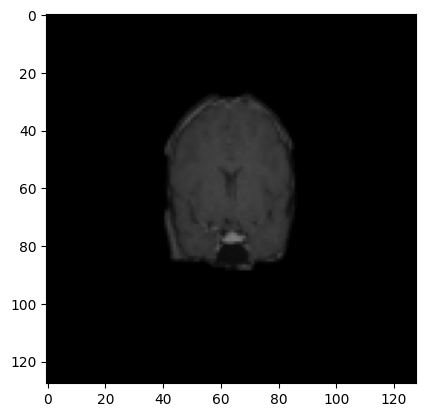

In [ ]:
plt.imshow(X_train[120,:,:,:]);

In [ ]:
print('Resizing masks.. ')
n=0
for i in mask_list:
    img = imread(i)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    Y_train[n] = img  #Fill empty X_train with values from img
    n += 1

Resizing masks.. 


In [ ]:
Y_train.shape

(219, 128, 128, 1)

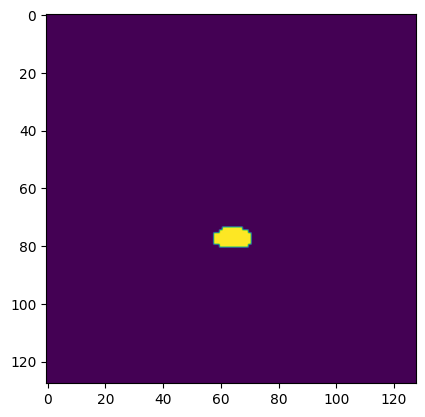

In [ ]:
plt.imshow(np.squeeze(Y_train[120,:,:,:]))
plt.show()

In [ ]:
import tensorflow.keras.metrics as metrics

In [ ]:




inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(),'accuracy'])
model.summary()

################################



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#################################Modelcheckpoint

#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=7, monitor='precision')]
#, callbacks=callbacks
results = model.fit(X_train, Y_train, batch_size=20, epochs=10)

Epoch 1/10
11/11 [==============================] - 53s 4s/step - loss: 0.2037 - precision: 9.7830e-04 - accuracy: 0.9803
Epoch 2/10
11/11 [==============================] - 47s 4s/step - loss: 0.0705 - precision: 0.0000e+00 - accuracy: 0.9834
Epoch 3/10
11/11 [==============================] - 46s 4s/step - loss: 0.0614 - precision: 0.7143 - accuracy: 0.9834
Epoch 4/10
11/11 [==============================] - 46s 4s/step - loss: 0.0569 - precision: 0.7059 - accuracy: 0.9834
Epoch 5/10
11/11 [==============================] - 46s 4s/step - loss: 0.0507 - precision: 0.9268 - accuracy: 0.9834
Epoch 6/10
11/11 [==============================] - 50s 4s/step - loss: 0.0448 - precision: 0.9333 - accuracy: 0.9834
Epoch 7/10
11/11 [==============================] - 46s 4s/step - loss: 0.0419 - precision: 0.8636 - accuracy: 0.9834
Epoch 8/10
11/11 [==============================] - 46s 4s/step - loss: 0.0412 - precision: 0.7179 - accuracy: 0.9834
Epoch 9/10
11/11 [==============================

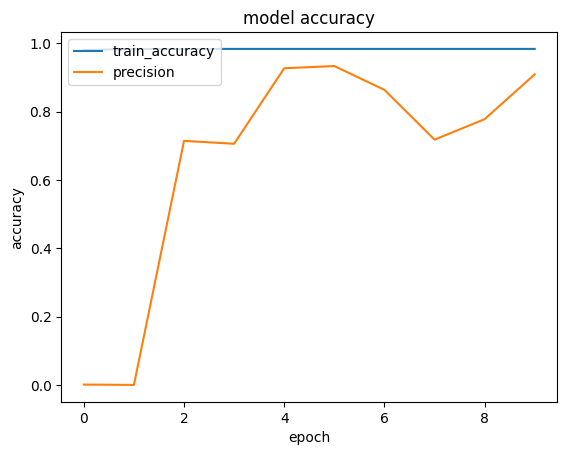

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy',"precision"], loc='upper left')
plt.show()

In [ ]:
idx = random.randint(0, 129)


train_predict = model.predict(X_train, verbose=1)
preds_train_t = (train_predict > 0.5).astype(bool)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

7/7 [==============================] - 9s 1s/step


In [ ]:
train_predict.shape

(219, 128, 128, 1)

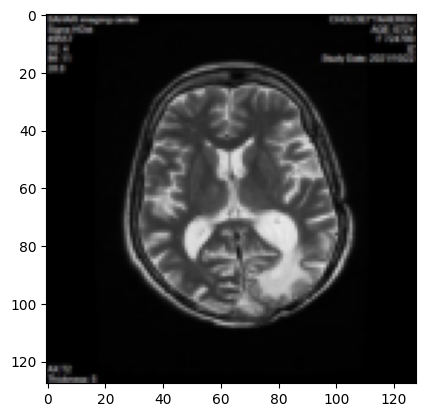

In [ ]:
plt.imshow(X_train[76,:,:,:]);

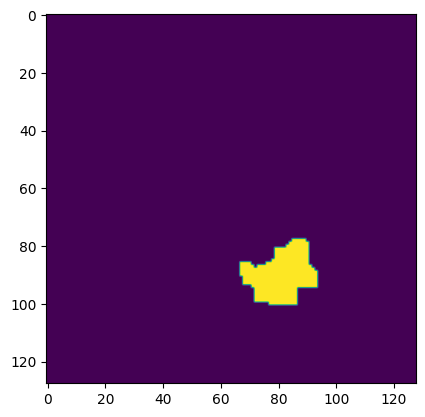

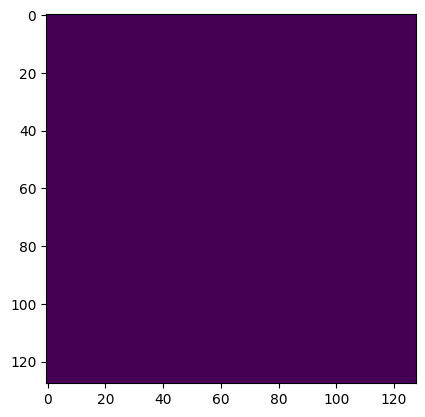

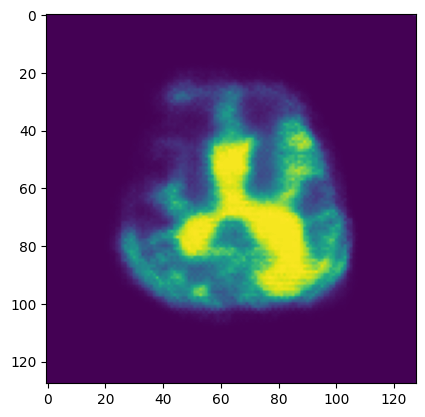

In [ ]:
j= 76
plt.imshow(np.squeeze(Y_train[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(train_predict[j,:,:,:]))
plt.show()

**TEST DATA CAME IN:**

In [ ]:
test = np.zeros((61, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


test_path = os.path.join(path, './test/')

test_list = os.listdir(test_path)
test_list = [test_path+i for i in test_list]
test_list.sort()


In [ ]:
print('Resizing mask images ')
n=0
for i in test_list:
    tst = imread(i)[:,:,:IMG_CHANNELS]
    tst = resize(tst, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test[n] = tst  #Fill empty test with values from tst
    n += 1

Resizing mask images 


In [ ]:
test_list[13]

'/content/gdrive/MyDrive/Dataset/./test/PAKE DEHI^ALI REZA_724870_49147_3_32.png'

In [ ]:
test.shape

(61, 128, 128, 3)

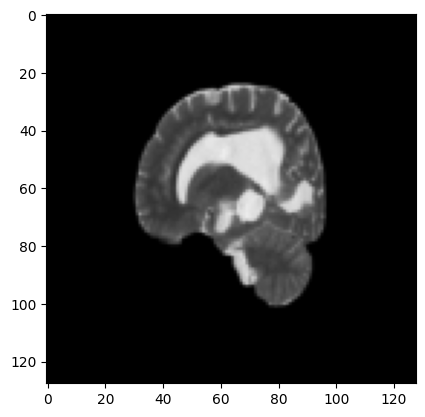

In [ ]:
plt.imshow(test[60,:,:,:]);

In [ ]:

test_predict = model.predict(test, verbose=1)
#preds_test_t = (test_predict > 0.5).astype(bool)



2/2 [==============================] - 2s 1s/step


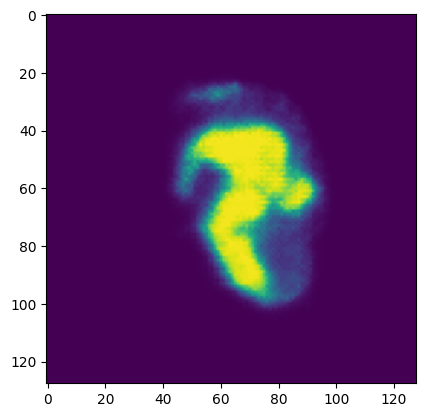

In [ ]:
i=60
plt.imshow(np.squeeze(test_predict[i,:,:,:]))
plt.show()

StopIteration: ignored

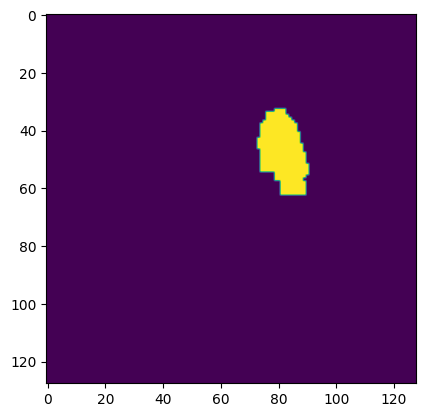

In [ ]:
plt.imshow(np.squeeze(Y_train[83,:,:,:]))



#Defining test dataset

TEST_PATH = 'test/'
test_ids = next(os.walk(TEST_PATH))[1]

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')



idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
plt.imshow(np.squeeze(Y_train[20,:,:,:]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[20,:,:,:]))

In [ ]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import distance_transform_edt

# Step 2: Load the predicted and ground truth masks
predicted_mask = test_predict
ground_truth_mask = train_predict

# Step 3: Calculate the distance maps
predicted_distance = distance_transform_edt(1 - predicted_mask)  # Invert mask for distance transform
ground_truth_distance = distance_transform_edt(1 - ground_truth_mask)

# Step 4: Compute the Hausdorff distance
hausdorff_distance = max(np.max(predicted_distance[ground_truth_mask]), np.max(ground_truth_distance[predicted_mask]))

# Step 5: Retrieve the Hausdorff distance
print("Hausdorff distance:", hausdorff_distance)


IndexError: ignored

In [ ]:
# Assuming the predicted_mask and ground_truth_mask are loaded as float arrays
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)
